In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import emoji
from wordcloud import WordCloud
from cleaner import clean_text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/airamariza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_parquet("train-00000-of-00001.parquet", engine="pyarrow")
test = pd.read_parquet("test-00000-of-00001.parquet", engine="pyarrow")

In [3]:
train = train[["text", "HATEFUL"]]
test = test[["text", "HATEFUL"]]

In [4]:
print(train.shape)
print(test.shape)

(36420, 2)
(11343, 2)


In [5]:
train["len_text_dirty"] = train["text"].apply(lambda x : len(x.split()))
test["len_text_dirty"] = test["text"].apply(lambda x : len(x.split()))

In [6]:
for column in train.columns:
  print(f"{column} tiene {train[column].isnull().sum()} NAs")

text tiene 0 NAs
HATEFUL tiene 0 NAs
len_text_dirty tiene 0 NAs


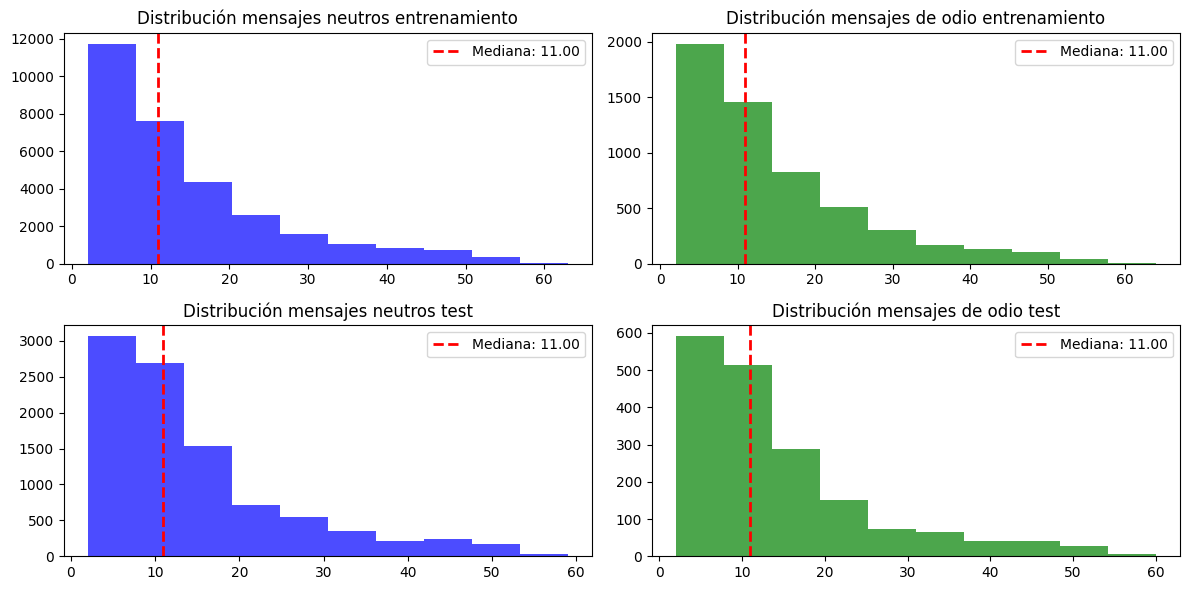

In [7]:

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Histograma para HATEFUL == 0
axes[0][0].hist(train["len_text_dirty"][train["HATEFUL"] == 0], color='blue', alpha=0.7)
axes[0][0].axvline(np.median(train["len_text_dirty"][train["HATEFUL"] == 0]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(train['len_text_dirty'][train['HATEFUL'] == 0]):.2f}"
)
axes[0][0].set_title("Distribución mensajes neutros entrenamiento")
axes[0][0].legend()

# Histograma para HATEFUL == 1
axes[0][1].hist(train["len_text_dirty"][train["HATEFUL"] == 1], color='green', alpha=0.7)
axes[0][1].axvline(np.median(train["len_text_dirty"][train["HATEFUL"] == 1]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(train['len_text_dirty'][train['HATEFUL'] == 1]):.2f}"
)
axes[0][1].set_title("Distribución mensajes de odio entrenamiento")
axes[0][1].legend()

# Histograma para HATEFUL == 0

axes[1][0].hist(test["len_text_dirty"][test["HATEFUL"] == 0], color='blue', alpha=0.7)
axes[1][0].axvline(np.median(test["len_text_dirty"][test["HATEFUL"] == 0]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(test['len_text_dirty'][test['HATEFUL'] == 0]):.2f}")
axes[1][0].set_title("Distribución mensajes neutros test")
axes[1][0].legend()

# Histograma para HATEFUL == 1
axes[1][1].hist(test["len_text_dirty"][test["HATEFUL"] == 1], color='green', alpha=0.7)
axes[1][1].axvline(np.median(test["len_text_dirty"][test["HATEFUL"] == 1]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(test['len_text_dirty'][test['HATEFUL'] == 1]):.2f}")
axes[1][1].set_title("Distribución mensajes de odio test")
axes[1][1].legend()

plt.tight_layout()
plt.show()


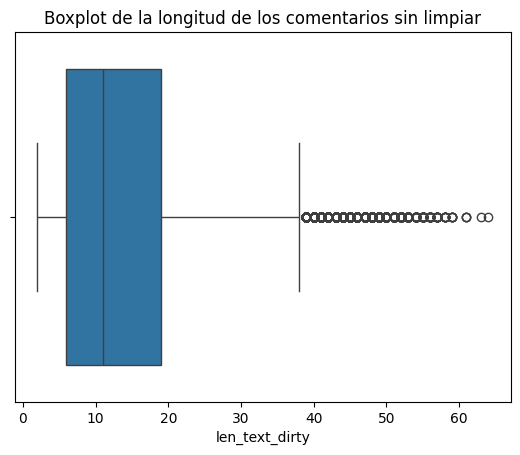

In [9]:
sns.boxplot(data["len_text_dirty"], orient = "h")
plt.title("Boxplot de la longitud de los comentarios sin limpiar")
plt.show()

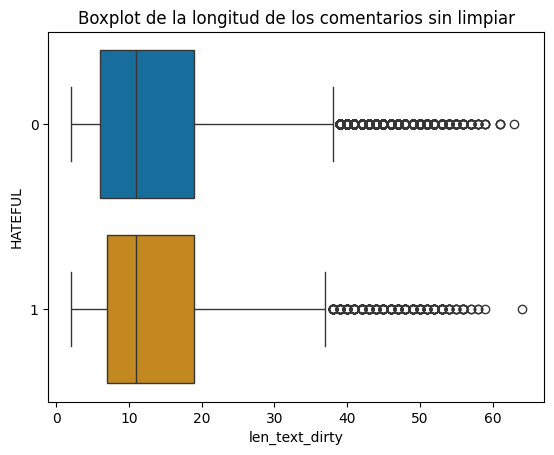

In [10]:
sns.boxplot(x = train["len_text_dirty"], y = train["HATEFUL"], orient = "h",palette= "colorblind")
plt.title("Boxplot de la longitud de los comentarios sin limpiar")
plt.show()

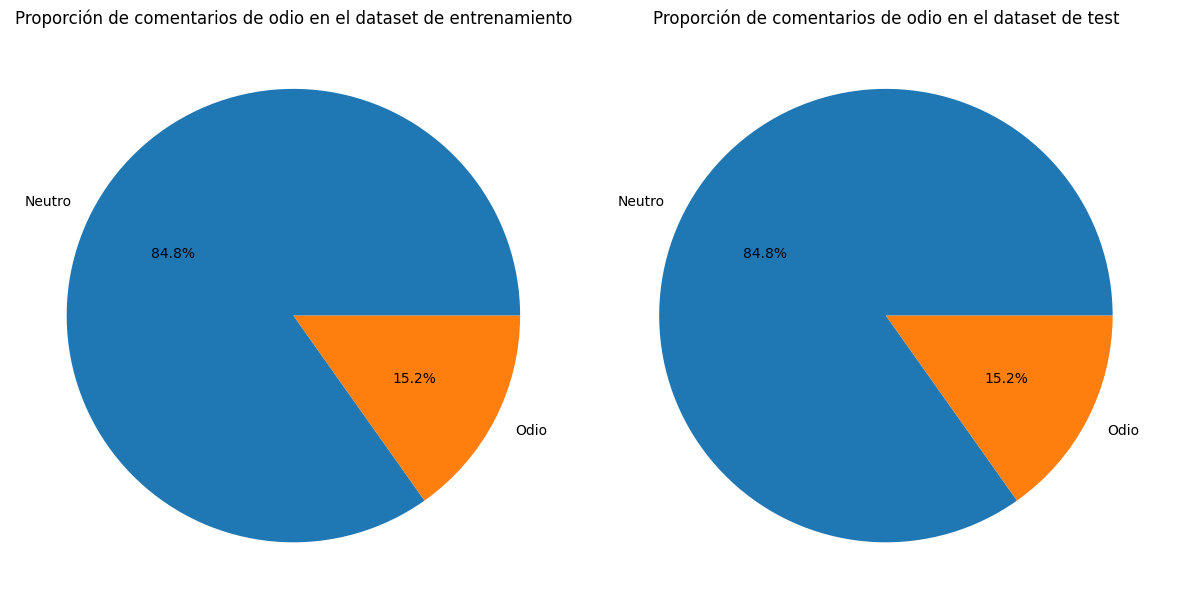

In [21]:
#Desbalanceo de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(train.value_counts(train["HATEFUL"]), labels = ["Neutro", "Odio"], autopct= "%.1f%%")
axes[0].set_title("Proporción de comentarios de odio en el dataset de entrenamiento")

axes[1].pie(train.value_counts(train["HATEFUL"]), labels = ["Neutro", "Odio"], autopct= "%.1f%%")
axes[1].set_title("Proporción de comentarios de odio en el dataset de test")

plt.tight_layout()
plt.show()

In [8]:
train["clean_text"] = clean_text(train["text"])
test["clean_text"] = clean_text(test["text"])

In [9]:
train["len_text_clean"] = train["clean_text"].apply(lambda x : len(x.split()))
test["len_text_clean"] = test["clean_text"].apply(lambda x : len(x.split()))

In [10]:
del_na_train = train["clean_text"][train["len_text_clean"] < 1].index
del_na_test = test["clean_text"][test["len_text_clean"] < 1].index

In [11]:
train = train.drop(del_na_train, axis = 0).reset_index(drop=True)
test = test.drop(del_na_test, axis = 0).reset_index(drop = True)

In [12]:
del_dup_train = train["clean_text"][train["clean_text"].duplicated()].index
del_dup_test = test["clean_text"][test["clean_text"].duplicated()].index

In [13]:
train = train.drop(del_dup_train, axis = 0).reset_index(drop=True)
test = test.drop(del_dup_test, axis = 0).reset_index(drop = True)

In [14]:
print(train.shape)
print(test.shape)

(33640, 5)
(10643, 5)


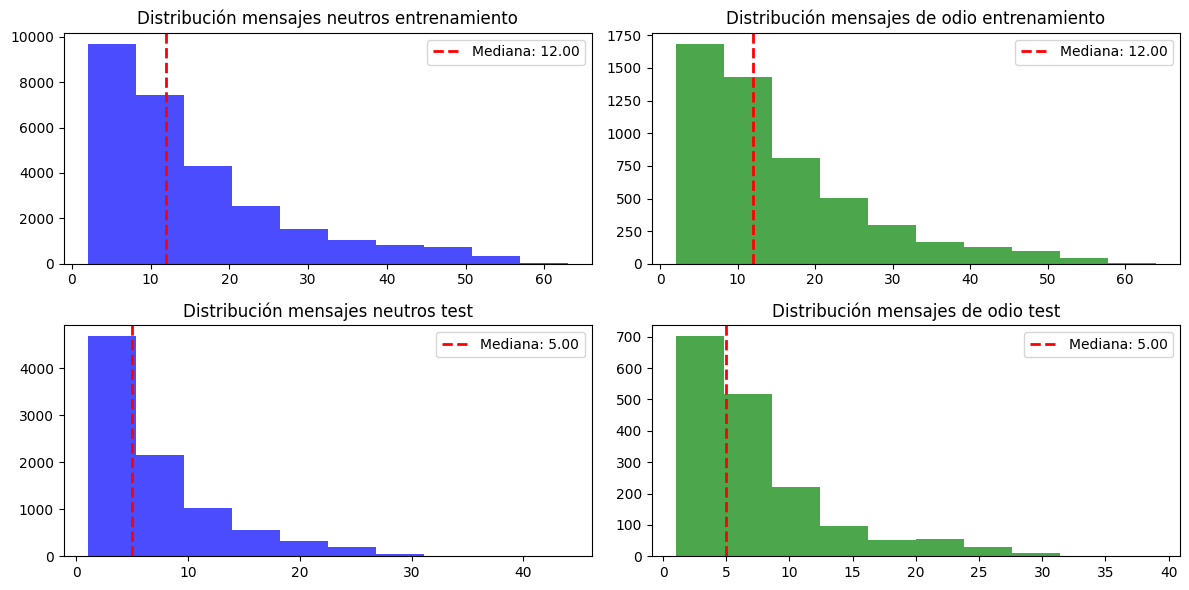

In [17]:

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Histograma para HATEFUL == 0
axes[0][0].hist(train["len_text_dirty"][train["HATEFUL"] == 0], color='blue', alpha=0.7)
axes[0][0].axvline(np.median(train["len_text_dirty"][train["HATEFUL"] == 0]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(train['len_text_dirty'][train['HATEFUL'] == 0]):.2f}"
)
axes[0][0].set_title("Distribución mensajes neutros entrenamiento")
axes[0][0].legend()

# Histograma para HATEFUL == 1
axes[0][1].hist(train["len_text_dirty"][train["HATEFUL"] == 1], color='green', alpha=0.7)
axes[0][1].axvline(np.median(train["len_text_dirty"][train["HATEFUL"] == 1]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(train['len_text_dirty'][train['HATEFUL'] == 1]):.2f}"
)
axes[0][1].set_title("Distribución mensajes de odio entrenamiento")
axes[0][1].legend()

# Histograma para HATEFUL == 0

axes[1][0].hist(test["len_text_clean"][test["HATEFUL"] == 0], color='blue', alpha=0.7)
axes[1][0].axvline(np.median(test["len_text_clean"][test["HATEFUL"] == 0]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(test['len_text_clean'][test['HATEFUL'] == 0]):.2f}")
axes[1][0].set_title("Distribución mensajes neutros test")
axes[1][0].legend()

# Histograma para HATEFUL == 1
axes[1][1].hist(test["len_text_clean"][test["HATEFUL"] == 1], color='green', alpha=0.7)
axes[1][1].axvline(np.median(test["len_text_clean"][test["HATEFUL"] == 1]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Mediana: {np.median(test['len_text_clean'][test['HATEFUL'] == 1]):.2f}")
axes[1][1].set_title("Distribución mensajes de odio test")
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [15]:
train["len_text_clean"].max()

42

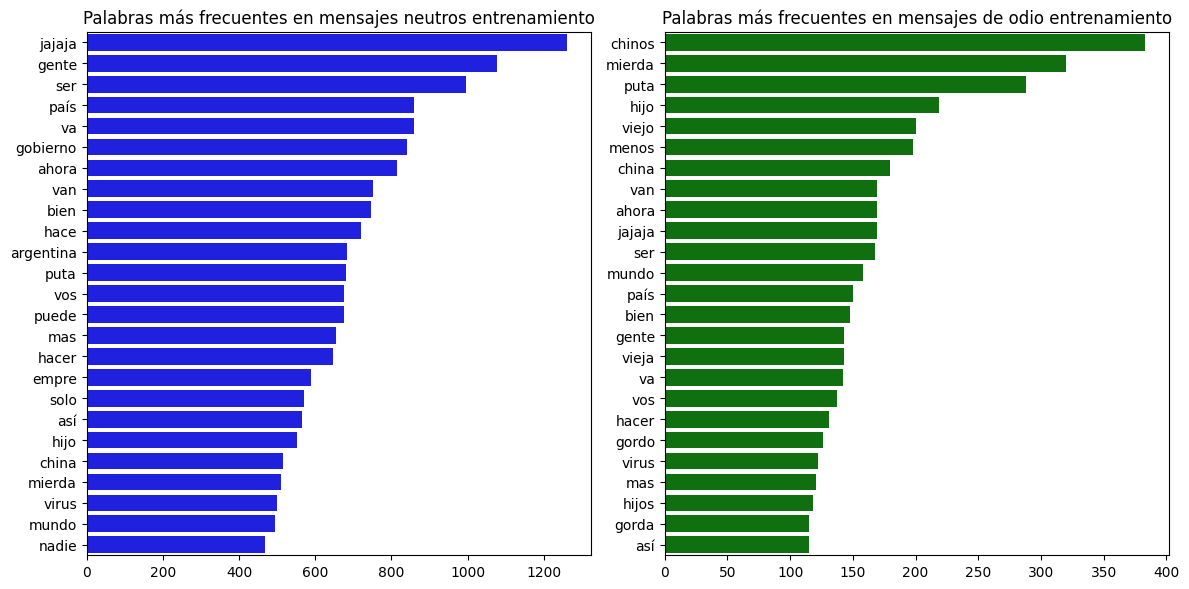

In [14]:

# Función modificada para aceptar un eje
def bar_plot(ax, text, color, n=10):
    all_words = [word for sublist in text.apply(lambda x: x.split()).tolist()
                 for word in sublist]

    contador = Counter(all_words)
    comunes = contador.most_common(n)
    x, y = zip(*comunes)

    sns.barplot(x=list(y), y=list(x), color=color, ax=ax)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Aplicar la función bar_plot a cada subplot
bar_plot(axes[0], train["clean_text"][train["HATEFUL"] == 0], "blue", 25)
axes[0].set_title("Palabras más frecuentes en mensajes neutros entrenamiento")

bar_plot(axes[1], train["clean_text"][train["HATEFUL"] == 1], "green", 25)
axes[1].set_title("Palabras más frecuentes en mensajes de odio entrenamiento")

plt.tight_layout()
plt.show()


In [15]:
train["proporcion_sw"] = np.round(1- (train["len_text_clean"] / train["len_text_dirty"]),4)

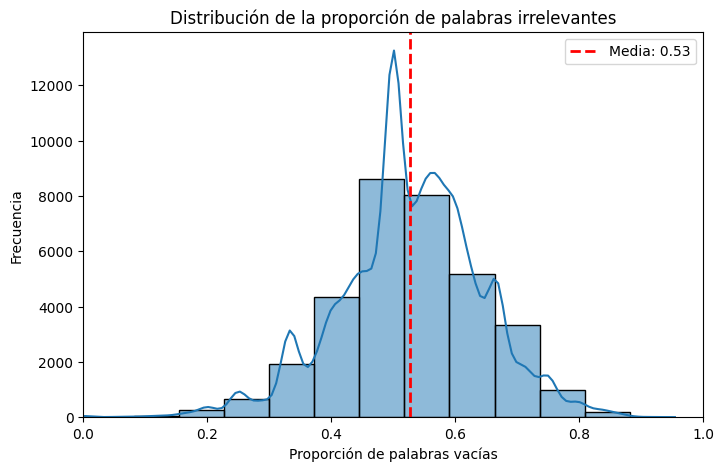

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(train["proporcion_sw"], bins=20, kde=True)
plt.axvline(np.mean(train["proporcion_sw"]), 
                 color='red', linestyle='dashed', linewidth=2, 
                 label=f"Media: {np.mean(train['proporcion_sw']):.2f}")
plt.legend()
plt.xlim([0,1])
plt.xlabel("Proporción de palabras vacías")
plt.ylabel("Frecuencia")
plt.title("Distribución de la proporción de palabras irrelevantes")

plt.show()

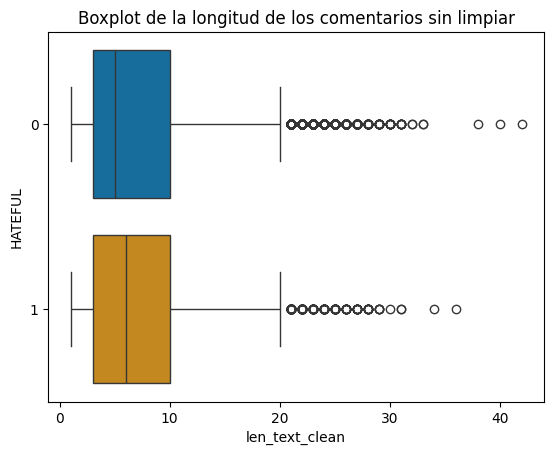

In [29]:
sns.boxplot(x = train["len_text_clean"], y = train["HATEFUL"], orient = "h",palette= "colorblind")
plt.title("Boxplot de la longitud de los comentarios sin limpiar")
plt.show()

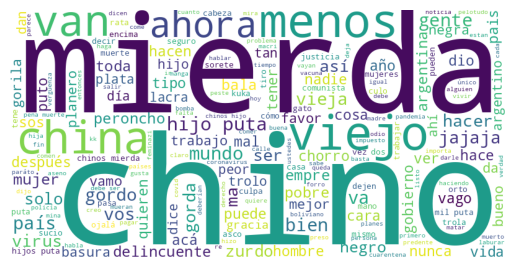

In [20]:
hateful_text = " ".join(train["clean_text"][train["HATEFUL"] == 1])
wordcloud = WordCloud(
    width=800, height=400,  
    background_color="white",    
    colormap="viridis",
    random_state= 42
).generate(hateful_text)

plt.imshow(wordcloud)
plt.axis("off")  # Ocultar ejes
plt.show()

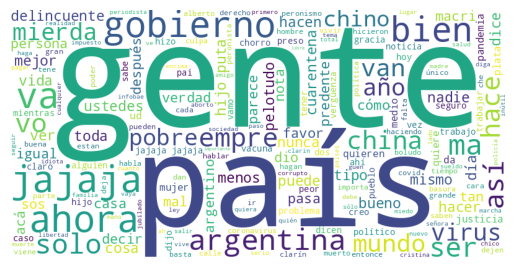

In [21]:
nhateful_text = " ".join(train["clean_text"][train["HATEFUL"] == 0])
wordcloud = WordCloud(
    width=800, height=400,  
    background_color="white",    
    colormap="viridis",
    random_state= 42
).generate(nhateful_text)

plt.imshow(wordcloud)
plt.axis("off")  # Ocultar ejes
plt.show()

In [29]:
def bigramas(text, title):

    all_words = [word for sublist in text.apply(lambda x: x.split()).tolist()
                 for word in sublist]
    

    
    bigrams = list(ngrams(all_words, 2))
    bigram_freq = Counter(bigrams)

    # Obtener los 10 bi-gramas más frecuentes
    most_common_bigrams = bigram_freq.most_common(10)
    labels = [' '.join(bigram) for bigram, _ in most_common_bigrams]
    counts = [count for _, count in most_common_bigrams]

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='#FF6F61')
    plt.xlabel('Frecuencia')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

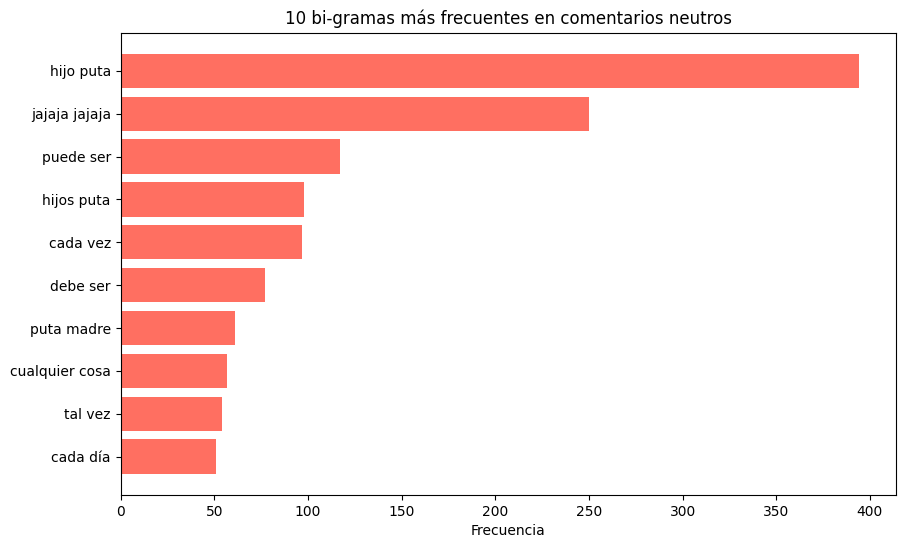

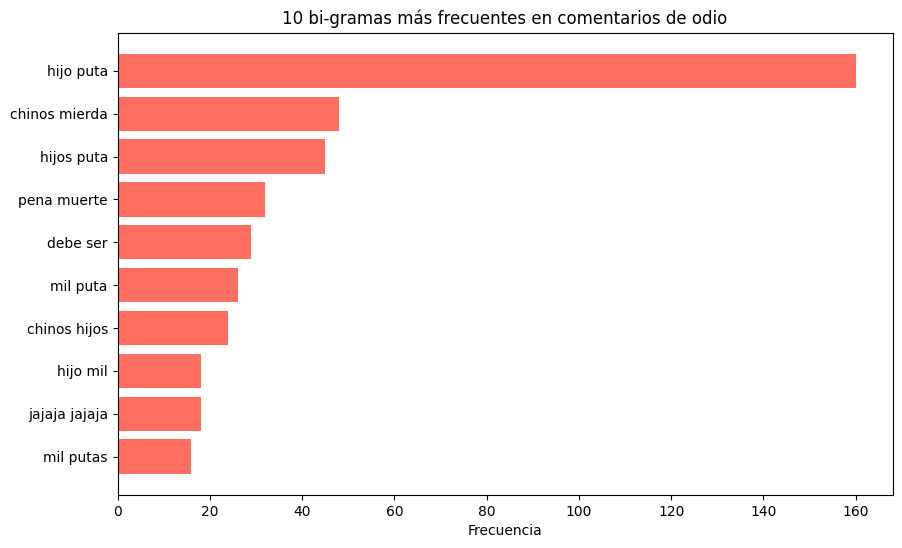

In [30]:
bigramas(train["clean_text"][train["HATEFUL"] == 0], 
         "10 bi-gramas más frecuentes en comentarios neutros")
bigramas(train["clean_text"][train["HATEFUL"] == 1],
         "10 bi-gramas más frecuentes en comentarios de odio")

In [31]:
train.to_parquet("train.parquet")
test.to_parquet("test.parquet")